In [1]:
import sys
import os
import pandas as pd
import numpy as np
import glob
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")


if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)

from utils.os_functions import ensure_data_dir
from utils.paths import PICARRO_DATA_DIRECTORY, PROCESSED_PICARRO_DATA_DIRECTORY

assert(os.path.exists(PICARRO_DATA_DIRECTORY))
assert(os.path.exists(PROCESSED_PICARRO_DATA_DIRECTORY))


## Expected Structure

```bash
📁 DEVICE NAME #picarro_device_folder 
    📁 YYYY #year          
        📁 MM #month
            📁 DD #day    
                📄 *.dat
            📁 ...
        📁 ...
    📁 ...
```

## Example

```bash
📁 ICOS_Picarro_G2401_529 #picarro_device_folder 
    📁 2025 #year          
        📁 01 #month
            📁 01 #day    
                📄 CFKADS2253-20250207-000005Z-DataLog_User.dat
            📁 ...
        📁 ...
    📁 ...

```

In [2]:
picarro_device_folders = ["DWD_Picarro_G2301_413", "ICOS_Picarro_G2401_529"]

structure = {}

for picarro_device_folder in picarro_device_folders:
    device_path = os.path.join(PICARRO_DATA_DIRECTORY, picarro_device_folder)
    years = [name for name in os.listdir(device_path) if os.path.isdir(os.path.join(device_path, name))]
    years.sort()
    
    structure[picarro_device_folder] = {}

    for year in years:
        sub_folder_year = os.path.join(PICARRO_DATA_DIRECTORY, picarro_device_folder, year)
        months = [name for name in os.listdir(sub_folder_year) if os.path.isdir(os.path.join(sub_folder_year, name))]
        months.sort()
        
        structure[picarro_device_folder][year] = str(months)
        
print(json.dumps(structure, indent=4))

{
    "DWD_Picarro_G2301_413": {
        "2023": "['07', '08', '09', '10', '11', '12']",
        "2024": "['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']"
    },
    "ICOS_Picarro_G2401_529": {
        "2024": "['09', '10', '11', '12']",
        "2025": "['01', '02', '03', '04', '05']"
    }
}


In [ ]:
# Choose what to import

config = {
    "ICOS_Picarro_G2401_529": {
        "2025": ["05"]
        }
}

In [4]:
def merge_picarro_files(base_path:str, device_name:str, year:str, month:str,  output_directory:str):

    path = os.path.join(base_path, device_name, year, month, "*/*.dat")
    filenames = glob.glob(path)

    df_list = []
    #read all files into pandas dataframe
    for filename in filenames:
        df_list.append(pd.read_csv(filename,sep=r'\s+'))

    # concat all read files
    df_picarro = pd.concat(df_list, ignore_index=True)
    
    # calculate datetime object for dataframe and sort by time
    df_picarro["datetime"] = pd.to_datetime((df_picarro['DATE'] + ' ' + df_picarro['TIME']))
    df_picarro.sort_values(by='datetime', inplace = True)
    
    # fix: some value seems to be a int in this float column
    df_picarro.EtalonTemp = pd.to_numeric(df_picarro.EtalonTemp, errors='coerce').fillna(0).astype(np.float64)
    
    # save dataframe as parquet file
    output_path = os.path.join(output_directory, device_name, year)
    ensure_data_dir(output_path)
    df_picarro.to_parquet(os.path.join(output_path,f"{month}_{device_name}.parquet"))
    
    print(f"Imported a total of {len(df_picarro)} rows for {device_name} in {year}/{month}")
    
    return df_picarro

In [5]:
for picarro_device_folder in config.keys():
    print(f"Processing device {picarro_device_folder}")
    device_path = os.path.join(PICARRO_DATA_DIRECTORY, picarro_device_folder)

    for year in config[picarro_device_folder].keys():
        print(f"Processing year {year}")
        sub_folder_year = os.path.join(PICARRO_DATA_DIRECTORY, picarro_device_folder, year)
        for month in config[picarro_device_folder][year]:
            print(f"Processing month {month}")
            df_p = merge_picarro_files(base_path=PICARRO_DATA_DIRECTORY, device_name=picarro_device_folder, year=year, month=month,  output_directory=PROCESSED_PICARRO_DATA_DIRECTORY)


Processing device ICOS_Picarro_G2401_529
Processing year 2025
Processing month 04
Imported a total of 4433745 rows for ICOS_Picarro_G2401_529 in 2025/04
Processing month 05
Imported a total of 2065194 rows for ICOS_Picarro_G2401_529 in 2025/05


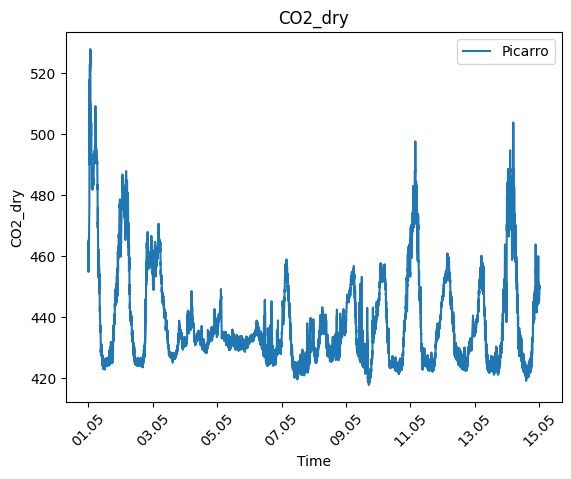

In [6]:
df_plot = df_p[["datetime", "CO2_dry"]] \
    .loc[(df_p['CO2_dry'] > 300) & (df_p['CO2_dry'] < 1000)] \
    .set_index("datetime") \
    .resample('1min').mean() 
    
# Ensure no inf values in df_plot
df_plot = df_plot.replace([float("inf"), float("-inf")], pd.NA).dropna()
    
# Plot using seaborn
sns.lineplot(data=df_plot, x=df_plot.index, y="CO2_dry", label="Picarro")

# Set axes labels
plt.xlabel("Time")
plt.ylabel("CO2_dry")
plt.xticks(rotation=45)

plt.title(label="CO2_dry")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

# Show the plot
plt.show()